# Algoritmo de eliminación de variables

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://static.thenounproject.com/png/542457-200.png" width="300px" height="300px" />

> **Objetivos:**
> - Describir intuitivamente el algoritmo de eliminación de variables.
> - Usar el algoritmo suma-producto para resolver preguntas de probabilidad condicional.
> - Usar el algoritmo max-suma para resolver preguntas de MAP.

> **References:**
> - Probabilistic Graphical Models: Principles and Techniques, By Daphne Koller and Nir Friedman. Ch. 9.
> - Pattern Recognition and Machine Learning, by Christopher M. Bishop - Cap. 8.
> - Bayesian Reasoning and Machine Learning by David Barber. Cap. 5.


<p style="text-align:right;"> Imagen recuperada de: https://static.thenounproject.com/png/542457-200.png.</p>

___

## 1. Eliminación de variables

Es el algoritmo de inferencia más simple y fundamental. Introduciremos el algoritmo mediante un ejemplo:

In [1]:
from IPython.display import Image

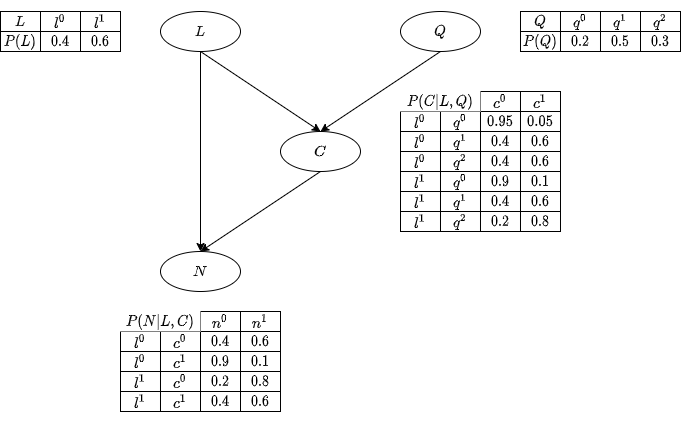

In [2]:
Image("figures/restaurant.png")

La probabilidad conjunta es:

$$P(L,Q,C,N)= \phi_L(L)\phi_Q(Q)\phi_C(C,L,Q)\phi_N(N,L,C).$$

Si queremos calcular $P(N)$ (<font color=blue>en el pizarrón, luego mostrar</font>):

<!--
$$\begin{align} P(N) = & \sum_{L,C,Q}\phi_L(L)\phi_Q(Q)\phi_C(C,L,Q)\phi_N(N,L,C) \\
                    = & \sum_{L}\sum_{C}\sum_{Q} \phi_L(L)\phi_Q(Q)\phi_C(C,L,Q)\phi_N(N,L,C) \\
                    = & \sum_{L}\sum_{C} \phi_L(L)\phi_N(N,L,C) \underbrace{\sum_{Q} \phi_Q(Q) \phi_C(C,L,Q)}_{\tau_1(C,L)} \\
                    = & \sum_{L} \phi_L(L) \underbrace{\sum_{C}\phi_N(N,L,C)\tau_1(C,L)}_{\tau_2(N,L)} \\
                    = & \sum_{L} \phi_L(L)\tau_2(N,L) = \tau_3(N)
\end{align}$$
-->

In [1]:
# Import pgmpy.models.BayesianModel
from pgmpy.models import BayesianModel

In [2]:
# Import pgmpy.factors.discrete.TabularCPD
from pgmpy.factors.discrete import TabularCPD

In [3]:
# Define model skeleton
restaurant_model = BayesianModel([
    ("L", "C"),
    ("Q", "C"),
    ("L", "N"),
    ("C", "N")
])

In [4]:
# Define factors
cpd_L = TabularCPD(
    variable="L",
    variable_card=2,
    values=[[0.4],
            [0.6]]
)
cpd_Q = TabularCPD(
    variable="Q",
    variable_card=3,
    values=[[0.2],
            [0.5],
            [0.3]]
)
cpd_C = TabularCPD(
    variable="C",
    variable_card=2,
    evidence=["L", "Q"],
    evidence_card=[2, 3],
    values=[[0.95, 0.4, 0.4, 0.9, 0.4, 0.2],
            [0.05, 0.6, 0.6, 0.1, 0.6, 0.8]]
)
cpd_N = TabularCPD(
    variable="N",
    variable_card=2,
    evidence=["L", "C"],
    evidence_card=[2, 2],
    values=[[0.4, 0.9, 0.2, 0.4],
            [0.6, 0.1, 0.8, 0.6]]
)

In [5]:
# Attach CPDs to the model
restaurant_model.add_cpds(
    cpd_L, cpd_Q, cpd_C, cpd_N
)

In [6]:
# Check if the model is correctly defined
restaurant_model.check_model()

True

In [7]:
# Import pgmpy.inference.VariableElimination
from pgmpy.inference import VariableElimination

In [8]:
# Create inference object
inference = VariableElimination(model=restaurant_model)

In [10]:
# Perform query
p_N = inference.query(variables=["N"])

Eliminating: L: 100%|██████████| 3/3 [00:00<00:00, 379.30it/s]


In [11]:
# Show
print(p_N)

+------+----------+
| N    |   phi(N) |
+======+==========+
| N(0) |   0.4452 |
+------+----------+
| N(1) |   0.5548 |
+------+----------+


**¿Qué sucede si tenemos evidencia?**

Ahora, calculemos $P(N, L=l^1)$:

- Primero, debemos reducir nuestros factores de acuerdo a la evidencia: $\phi_L(l^1)=\phi_L'()$, $\phi_C(C,l^1,Q)=\phi_C'(C,Q)$, $\phi_N(N,l^1,C)=\phi_N'(N,C)$.
- Después, ejecutamos el algoritmo normalmente:

<!--
$$\begin{align} P(N, l^1) = & \sum_{C,Q}\phi_L'()\phi_Q(Q)\phi_C'(C,Q)\phi_N'(N,C) \\
                         = & \sum_{C}\sum_{Q} \phi_L'()\phi_Q(Q)\phi_C'(C,Q)\phi_N'(N,C) \\
                         = & \sum_{C} \phi_L'()\phi_N'(N,C) \underbrace{\sum_{Q} \phi_Q(Q) \phi_C'(C,Q)}_{\tau_1(C)} \\
                         = & \sum_{C} \phi_L'()\phi_N'(N,C) \tau_1(C)
\end{align}$$
-->

**Y, ¿Si queremos la probabilidad condicional?**

Entonces, solo debemos normalizar:

$$P(N|l^1)=\frac{P(N,l^1)}{P(l^1)}.$$

In [12]:
inference.query?

In [13]:
# Perform query
p_N_given_l1 = inference.query(
    variables=["N"],
    evidence={"L": 1}
)

Eliminating: C: 100%|██████████| 2/2 [00:00<00:00, 467.77it/s]


In [14]:
# Show
print(p_N_given_l1)

+------+----------+
| N    |   phi(N) |
+======+==========+
| N(0) |   0.3120 |
+------+----------+
| N(1) |   0.6880 |
+------+----------+


### Formalmente

El proceso de eliminar alguna variable $Z$ de un conjunto de factores $\bar{\Phi}$, se puede describir como:

1. Determinar el conjunto de factores que involucran a la variable $Z$:

   $$\Phi' = \left\{\phi_i \in \Phi : Z  \in \mathrm{scope}[\phi_i]\right\}$$

2. Calcular el producto:

   $$\psi = \prod_{\phi_i \in \Phi'} \phi_i$$
   
3. Calcular la marginalización:

   $$\tau = \sum_Z \psi$$
   
4. Sobreescribir el conjunto de factores original:
   
   $$\bar{\Phi} := \left(\bar{\Phi}\setminus \Phi'\right) \cup \{\tau\}$$

Por tanto, el algoritmo completo puede describirse como:

1. El primer paso es reducir todos los factores de acuerdo a la evidencia, si es que hay.

2. Para cada variable $Z$ que no sea de interés:
   - Eliminar la variable $Z$ de $\bar{\Phi}$.

3. Multiplicar los factores restantes.

## 2. Importancia del orden de eliminación

El resultado final del algoritmo de eliminación de variables es invariante ante diferentes órdenes de eliminación. Sin embargo, la complejidad computacional puede cambiar dramáticamente dependiendo del orden de eliminación elegido.

Por ejemplo, retomamos el ejemplo del restaurante.

1. $Q-C-L$
   
   - Operation: $\tau_1(C,L)=\sum_{Q}\phi_Q(Q)\phi_C(C,L,Q)$
   
   - Operation: $\tau_2(N,L)=\sum_{C}\phi_N(N,L,C)\tau_1(C,L)$

   - Operation: $\tau_3(N)=\sum_{L}\phi_L(L)\tau_2(N,L)$

In [17]:
inference.query?

In [18]:
# Perform query with given elimination order
%timeit inference.query(variables=["N"], elimination_order=["Q", "C", "L"], show_progress=False)

5.71 ms ± 133 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
print(inference.query(variables=["N"], elimination_order=["Q", "C", "L"], show_progress=False))

+------+----------+
| N    |   phi(N) |
+======+==========+
| N(0) |   0.4452 |
+------+----------+
| N(1) |   0.5548 |
+------+----------+


2. $L-C-Q$

   - Operation: $\tau_1(Q,C,N) = \sum_{L} \phi_L(L) \phi_C(C,L,Q) \phi_N(N,L,C)$

   - Operation: $\tau_2(Q,N) = \sum_{C} \tau_1(Q,C,N)$

   - Operation: $\tau_3(Q) = \sum_{Q} \phi_Q(Q)\tau_2(Q,N)$

In [19]:
# Perform query with given elimination order
%timeit inference.query(variables=["N"], elimination_order=["L", "C", "Q"], show_progress=False)

5.99 ms ± 178 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
print(inference.query(variables=["N"], elimination_order=["L", "C", "Q"], show_progress=False))

+------+----------+
| N    |   phi(N) |
+======+==========+
| N(0) |   0.4452 |
+------+----------+
| N(1) |   0.5548 |
+------+----------+


### Entonces, ¿Cómo podemos elegir el orden de eliminación?

Se pueden obtener ideas bastante buenas de la representación gráfica. No cubriremos esto acá pero puedes revisar la Sección 9.4, páginas 305-315 de Probabilistic Graphical Models: Principles and Techniques.

En la práctica, normalmente se usan algoritmos **greedy** con funciones heurísticas de costo: 

> En cada iteración se calcula qué variable eliminar para obtener el menor costo local.

> These algorithms are not optimal, but perform sufficiently well. 

Funciones de costo comunes:

- min-weight: # de valores del factor intermedio $\psi$.
- min-neighbors: # de nodos resultantes después de la elimionación.
- min-fill: # de arcos nuevos de relleno.

In [23]:
inference.query?

In [29]:
# min-weight
print(inference.query(variables=["N"], elimination_order="MinWeight"))

Eliminating: L: 100%|██████████| 3/3 [00:00<00:00, 318.51it/s]

+------+----------+
| N    |   phi(N) |
+======+==========+
| N(0) |   0.4452 |
+------+----------+
| N(1) |   0.5548 |
+------+----------+


In [28]:
# min-neighbors
print(inference.query(variables=["N"], elimination_order="MinNeighbors"))

Eliminating: L: 100%|██████████| 3/3 [00:00<00:00, 496.27it/s]

+------+----------+
| N    |   phi(N) |
+======+==========+
| N(0) |   0.4452 |
+------+----------+
| N(1) |   0.5548 |
+------+----------+


In [30]:
# min-fill (default)
print(inference.query(variables=["N"], elimination_order="MinFill"))

Eliminating: L: 100%|██████████| 3/3 [00:00<00:00, 324.63it/s]

+------+----------+
| N    |   phi(N) |
+======+==========+
| N(0) |   0.4452 |
+------+----------+
| N(1) |   0.5548 |
+------+----------+


## 3. Eliminación max-producto

Hasta ahora hemos visto el algoritmo de suma-producto para realizar inferencias del tipo de probabilidad condicional.

¿Cómo podemos realizar inferencias del tipo MAP?

**La respuesta es: muy similarmente.** Veámoslo a través de un ejemplo:

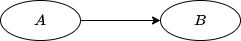

In [4]:
Image("figures/simpleExample.png")

Nuestro objetivo es calcular:

$$\begin{align}
\max_{a,b} P(A=a, B=b)  & = \max_{a,b} P(A=a)P(B=b | A=a) \\
                        & = \max_{a} \max_{b} P(A=a)P(B=b | A=a).
\end{align}$$

De esta expresión, deberíamos elegir $a$ de forma que:

$$\max_{b} P(A=a)P(B=b | A=a) = P(A=a) \max_{b}P(B=b | A=a)$$

sea máximo. De manera que,

- Una **condición necesaria** de la asignación MAP $a,b$ es que $b$ se selecciones para maximizar $P(B=b | A=a)$. 

- Esto no es suficiente, pues debemos elegir $a$ apropiadamente.

Por ejemplo, considere las siguientes CPDs

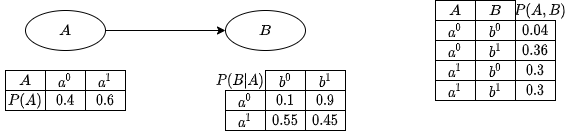

In [5]:
Image("figures/simpleExample2.png")

Denotemos $\max_{b}P(B=b | A=a) = \phi_1(a)$. Luego

- $\phi_1(a^0)=0.9$
- $\phi_1(a^1)=0.55$

Finalmente,

$$\max_{a} P(a) \phi_1(a) = \max_{a} \phi_2(a)=0.36$$

| $A$ | $\phi_2$           |
| --- | ------------------ |
|$a^0$|$0.9\times0.4=0.36$ |
|$a^1$|$0.55\times0.6=0.33$|

### Comentarios importantes:

- Podemos notar que la operación $\max_{b}P(B=b | A=a) = \phi_1(a)$ corresponde a una *max-marginalización* del factor $P(B|A)$.

- Tal como en inferencia de probabilidad condicional, este paso marginaliza la variable $B$, no por suma, sino por una maximización.

- Punto clave: supongamos que tenemos dos factores $\phi_1,\phi_2$ tales que $X\notin \mathrm{scope}[\phi_1]$, entonces

  $$\max_{X} \phi_1 \phi_2 = \phi_1 \max_{X} \phi_2.$$
 
  Esto es, podemos "introducir" las operaciones de maximización (tal y como lo hicimos con las sumas) sobre los factores que no dependen de la variables siendo maximizada. Similarmente,
  
  $$\max_{X} (\phi_1 + \phi_2) = \phi_1 + \max_{X} \phi_2.$$

Este último comentario nos lleva directamente a los algoritmos de **eliminación de variables max-producto and max-suma** los cuales son completamente duales al algoritmo de **suma-producto** que vimos al inicio de est notebook.

### Algoritmo max-producto
   
1. Determinar el conjunto de factores que involucran a la variable $Z$:

   $$\Phi' = \left\{\phi_i \in \Phi : Z  \in \mathrm{scope}[\phi_i]\right\}$$

2. Calcular el producto:

   $$\psi = \prod_{\phi_i \in \Phi'} \phi_i$$
   
3. Calcular la max-marginalización:

   $$\tau = \max_Z \psi$$
   
   Y guardar la variable $z^\ast$ que maximiza $\psi$.
   
4. Sobreescribir el conjunto de factores original:
   
   $$\bar{\Phi} := \left(\bar{\Phi}\setminus \Phi'\right) \cup \{\tau\}$$

### Algoritmo max-suma

A menudo, los valores de algunos factores son tan pequeños (probabilidad) que cuando los multiplicamos, producen valores aún más pequeños que la resolución de nuestra memoria: **underflow numérico**.

Una manera efectiva de trabajar con esta situación es considerar el $\log$ de los factores.

Tenemos que:

$$P_{\bar{\Phi}} (\bar{X}) \propto \prod_{k} \phi_{k} (\bar{X}_k)$$

y queremos,

$$\arg \max_{X} \prod_{k} \phi_{k} (\bar{X}_k) = \arg \max_{X} \log\left(\prod_{k} \phi_{k} (\bar{X}_k)\right) = \arg \max_{X} \sum_{k} \log\left(\phi_{k} (\bar{X}_k)\right),$$

dado que el $\log$ es una función creciente.

Así, convirtiendo los factores con el logaritmo, nos permite intercambiar productos por sumas, obteniendo cierta **robustez práctica contra el underflow numérico**.

El algoritmo es completamente análogo:

### Max-sum variable elimination algorithm

0. Tomar el $\log$ de cada factor:

   $$\theta_k(\bar{X}_k) = \log{\phi_k}(\bar{X}_k).$$
   
   $$\bar{\Theta} = \{\theta_{1}(\bar{X}_1), \dots, \theta_{m}(\bar{X}_m)\}.$$

1. Determinar el conjunto de factores que involucran a la variable $Z$:

   $$\bar{\Theta}' = \left\{\theta_i \in \bar{\Theta} : Z  \in \mathrm{scope}[\theta_i]\right\}$$

2. Calcular la suma:

   $$\psi = \sum_{\theta_i \in \bar{\Theta}'} \phi_i$$
   
3. Calcular la max-marginalización:

   $$\tau = \max_Z \psi$$
   
   Y guardar la variable $z^\ast$ que maximiza $\psi$.
   
4. Sobreescribir el conjunto de factores original:
   
   $$\bar{\Theta} := \left(\bar{\Theta}\setminus \bar{\Theta}'\right) \cup \{\tau\}$$

In [31]:
# Create VariableElimination inference object
print(inference.map_query(variables=["N"],
                          evidence={"Q": 2}))

Eliminating: L: 100%|██████████| 2/2 [00:00<00:00, 240.04it/s]

{'N': 1}


In [32]:
# Map query
print(inference.map_query(variables=["Q", "L"],
                          evidence={"N": 1}))

Eliminating: C: 100%|██████████| 1/1 [00:00<00:00, 328.53it/s]

{'Q': 1, 'L': 1}


In [33]:
print(inference.map_query(variables=["Q", "L"],
                          evidence={"N": 1, "C": 1}))

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

{'Q': 1, 'L': 1}


# 4. Aplicación - Clasificación

Usemos el ejemplo de la clase 1

| Type of flower | label  |
| -------------- | ------ |
| Setosa         | 0      |
| Versicolor     | 1      |
| Virginica      | 2      |

In [34]:
# Library imports (sklearn.datasets.load_iris, pandas y numpy)
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np

/home/esteban/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [35]:
# Data loading (integer parts, for simplicity)
iris = load_iris()
X = iris['data'][:, :2].astype(int)
y = iris['target']
df = pd.DataFrame(X, columns=['sepal_length', 'sepal_width'])
df['target'] = y
df

,sepal_length,sepal_width,target
0,5,3,0
1,4,3,0
2,4,3,0
3,4,3,0
4,5,3,0
...,...,...,...
145,6,3,2
146,6,2,2
147,6,3,2
148,6,3,2


In [36]:
# Import matplotlib.pyplot
import matplotlib.pyplot as plt

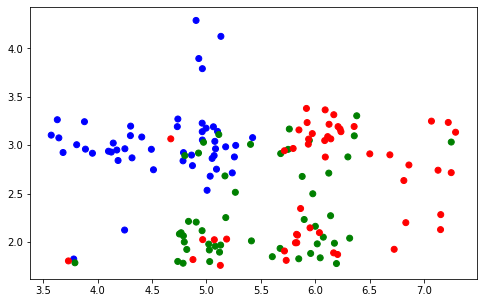

In [37]:
# Scatter plot (largo vs. ancho), color regarding type of flower. Add a bit of noise
l = df['sepal_length'] + np.random.normal(0, 0.2, (len(df), ))
w = df['sepal_width'] + np.random.normal(0, 0.2, (len(df), ))
plt.figure(figsize=(8, 5))
plt.scatter(l, w, c=['bgr'[c] for c in df['target']])
plt.show()

In [45]:
from IPython.display import Image

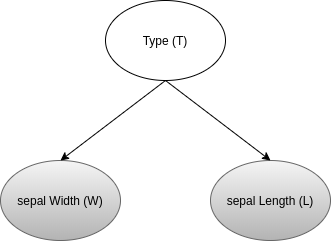

In [46]:
Image('figures/iris.png')

In [47]:
# Flower model
flower_model = BayesianModel([
    ("target", "sepal_length"),
    ("target", "sepal_width"),
])

In [48]:
# Train/test split
train = df.sample(frac=0.9)
test = df[~df.index.isin(train.index)]

In [51]:
# Train model
flower_model.fit(train)

In [55]:
# Predict (MAP Assignment)
test["pred"] = flower_model.predict(
    test.drop(columns=["target"])).values.ravel()

100%|██████████| 7/7 [00:00<00:00, 284.87it/s]
/home/esteban/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [56]:
# Accuracy
test

,sepal_length,sepal_width,target,pred
15,5,4,0,0
20,5,3,0,0
35,5,3,0,0
40,5,3,0,0
54,6,2,1,1
55,5,2,1,1
67,5,2,1,1
77,6,3,1,2
79,5,2,1,1
84,5,3,1,0


In [57]:
(test["target"] == test["pred"]).mean()

0.7333333333333333

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>